# Testing the Mean Field

In this notebook I will test the quality of the meanfield approximation with regards to 1) system size and 2) network structure.

First I set up the meanfield model for simulations and some helper functions. 

In [1]:
using Pkg

Pkg.activate("..")

using DiffEqBase, OrdinaryDiffEq, Plots
using Random, StatsBase, DelimitedFiles, Distributions
using SymPy, LinearAlgebra
using LaTeXStrings, Combinatorics

  Activating environment at `~/Projects/Submitted/TemperatureAmplification/Project.toml`


In [2]:
#define parameter structure
struct params
    r::Vector{Float64}
    R::Vector{Float64}
    a::Array{Float64,2}
    ψ::Float64
    Nsp::Int8
end

#define GLV model
function dC!(dC,C,p,t)
    for i = 1:p.Nsp
        dC[i] = C[i] * p.r[i]
        for j = 1:p.Nsp
            dC[i] += C[i] * C[j] * p.a[i,j]
        end
    end
end

function dC_mean!(dC,C,p,t)
    for i = 1:p.Nsp
        dC[i] = (C[i] * p.r[i]) + (C[i] * C[i] * p.a[i,i]) + (p.Nsp * C[i] * mean(C) * p.ψ)
    end
end

function mean_nodiag(A)
    (sum(A) - sum([A[i,i] for i = 1:size(A)[1]]) ) / (size(A)[1] * (size(A)[1]-1) )
end

function random_community(N,ā)
    a = ā .+ (randn(N,N)) / 10
    [a[i,i] = -1 for i = 1:N]
    params(rand(N),rand(N),a, ā, N)
end

random_community (generic function with 1 method)

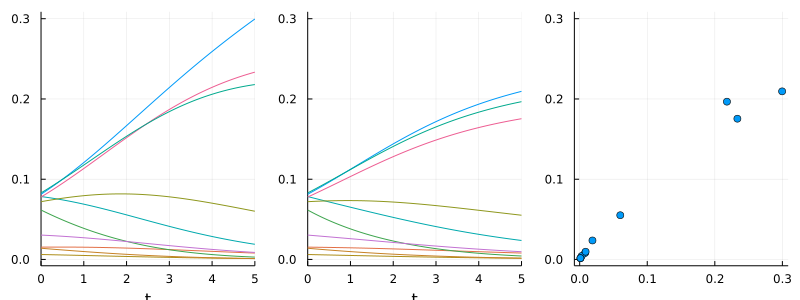

In [3]:
# Random.seed!(6)
Nsp = 10
p = random_community(Nsp, -1)
C0 = rand(Nsp) ./ Nsp
tspan = (0.0,5.0)

prob_1 = ODEProblem(dC!, C0, tspan, p)
sol_1 = DiffEqBase.solve(prob_1, AutoTsit5(Rosenbrock23()))
plot_1 = plot(sol_1, legend = false)

prob_2 = ODEProblem(dC_mean!, C0, tspan, p)
sol_2 = solve(prob_2, AutoTsit5(Rosenbrock23()))
plot_2 = plot(sol_2, legend = false)

plot_3 = scatter(sol_1[end], sol_2[end], legend = false)

plot(plot_1, plot_2, plot_3, link = :y, layout = (1,3), size = (800,300))

Here is a basic comparison of the full GLV (left) the meanfield approximation (center) and the correspondance of biomass estimates (right) showing reasonalble correspondance between the results. 

## System size
Now I move on to look at system size asking how good is the mean field as system becomes smaller?

In [25]:
function mean_error(N, seed, ā)
    Random.seed!(seed)
    
    p = random_community(N,ā)
    C0 = rand(N) ./ N
    tspan = (0.0,2.0)
    
    prob_1 = ODEProblem(dC!, C0, tspan, p)
    sol_1 = solve(prob_1, AutoTsit5(Rosenbrock23()))
    
    prob_2 = ODEProblem(dC_mean!, C0, tspan, p)
    sol_2 = solve(prob_2, AutoTsit5(Rosenbrock23()))
    
    error = sum(sol_1[end] ./ sol_2[end]) / N
    
    return( (1 - error) * 100 )
end
    

mean_error (generic function with 1 method)

### With N species

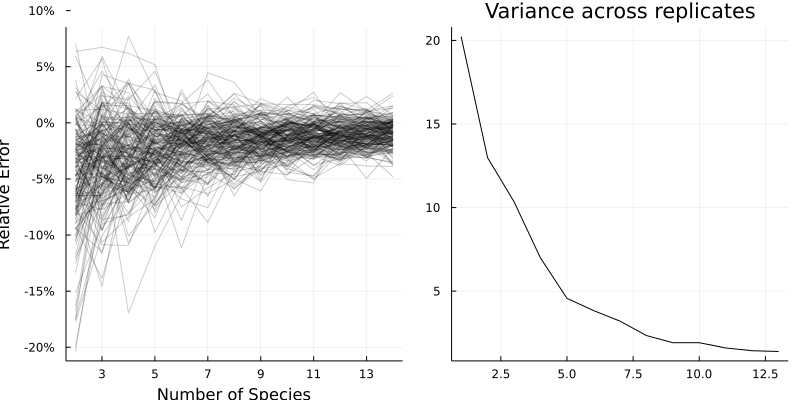

In [28]:
N_max = 14
N_rep = 200
N_int = 1

int_vec = -0.1 #range(-0.1,0.1, length = N_int)

res_error = zeros(N_max, N_rep, N_int)

for Nsp = 1:N_max, rep = 1:N_rep, int = 1:N_int
    res_error[Nsp, rep, int] = mean_error(Nsp, rep, int_vec[int])
end

p = plot(legend = false, xlab = "Number of Species", ylab = "Relative Error")

for rep = 1:N_rep
    for int = 1:N_int
       plot!(p, 2:N_max, res_error[2:N_max,rep,int], line_z = int_vec[int], alpha = 0.2)
    end
end

y_ticks = -20:5:20
y_ticklab = string.(y_ticks, "%")
yticks!(p, y_ticks, y_ticklab)

x_ticks = 1:2:N_max
xticks!(p, x_ticks)

plot(p,
    plot(var(res_error, dims = 2)[2:N_max,1,:],
        title = "Variance across replicates", line_z = int_vec', legend = false, label = string.(int_vec')),
    size = (800,400))

Moving along the x-axis as the number of species increases the relative error of the mean field approximation falls. 

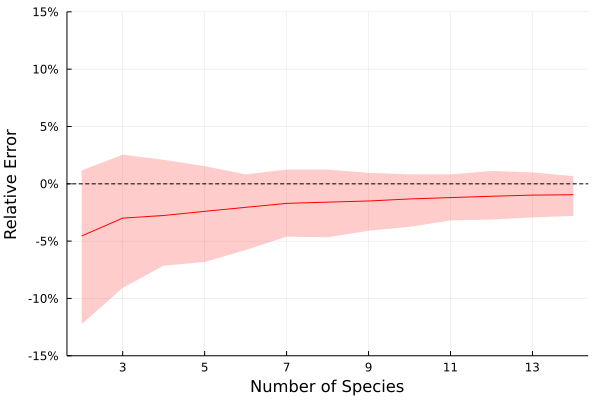

In [29]:
mean_err = mapslices(mean, res_error, dims = 2)[2:end,1,1]
err = mapslices(x -> abs.(mean(x) .- quantile(x, [0.05, 0.95])), res_error[:,:,1], dims = 2)[2:end,:]

p = plot(2:14,mean_err, ribbon = (err[:,1],err[:,2]), xlab = "Number of Species", ylab = "Relative Error", legend = false, color = "red", fillalpha = 0.2)

y_ticks = -20:5:20
y_ticklab = string.(y_ticks, "%")
yticks!(p, y_ticks, y_ticklab)

x_ticks = 1:2:N_max
xticks!(p, x_ticks)

ylims!(p, -15, 15)

hline!(p, [0.0], color = "black", style = :dash)


In [30]:
savefig(p, "../plots/FigS4_meanfield2.pdf")

Looking across system size we can see that the variance in relative error decays quickly as size increases. By the time that we reach 5 species the error of most replicates is within 10%.  

## Network structure

In this section I test different aspects of network structure including:
- Variation in interaction strengths
- Intransitvity

### Intransitvity

In [31]:
function intrans_community(ā, loop_max, B, N)
    @assert loop_max ≤ N

    ā = 0.1
    loop_max = 5
    B = -0.5
    N = 5

    a = (randn(N,N) ./ 10 ) .+ ā
    #add intraspecific interactions
    [a[i,i] = -1.0 for i = 1:N]

    #get indicies
    comb = combinations(1:N,loop_max) |> collect
    intrans_ind_1 = [[comb[1][i],circshift(comb[1],1)[i]] for i = 1:loop_max]
    intrans_ind_2 = [[circshift(comb[1],1)[i],comb[1][i]] for i = 1:loop_max]

    #add intransitive interactions
    a_non_int = 0.0
    a_int = 0.0
    for i = 1:N
        for j = 1:N
            if [i,j] ∈ intrans_ind_1
                a[i,j] = B
                a_int += B
            elseif [i,j] ∈ intrans_ind_2
                a[i,j] = 0.0
            elseif i ≠ j
                a_non_int += a[i,j]
            end
        end
    end

    #target a
    N_tot = (N^2) - N
    N_int = N_tot - 2*loop_max
    N_n_int = N_tot - N_int

    a_target = (N_tot) * ā
    a_actual = a_non_int + a_int
    a_diff = a_target - a_actual 

    A = a_diff / N_n_int

    for i = 1:N
        for j = 1:N
            if ([i,j] ∉ intrans_ind_1) & ([i,j] ∉ intrans_ind_2) & (i≠j)
                a[i,j] += A
            end
        end
    end

    return(params(rand(N),rand(N),a, ā, N))
end

intrans_community (generic function with 1 method)

In [32]:
function mean_error_intrans(N,loop,B,seed,ā)
    Random.seed!(seed)
    
    p = intrans_community(ā, loop, B, N)

    C0 = rand(N) ./ N
    tspan = (0.0,2.0)
    
    prob_1 = ODEProblem(dC!, C0, tspan, p)
    sol_1 = solve(prob_1, AutoTsit5(Rosenbrock23()))
    
    prob_2 = ODEProblem(dC_mean!, C0, tspan, p)
    sol_2 = solve(prob_2, AutoTsit5(Rosenbrock23()))
    
    error = sum(sol_1[end] ./ sol_2[end]) / N
    
    return((1 - error) * 100)
end
    

mean_error_intrans (generic function with 1 method)

In [33]:
N_rep = 100
N_B = 20
B_vec = range(0.0, -2.0, length = 20)

res = zeros(5,N_B,N_rep)

#get avg error across sp biomasses
for l = 1:5, B = 1:N_B, rep = 1:N_rep
    res[l,B,rep] = mean_error_intrans(5,l,B_vec[B],rep,-0.5)
end

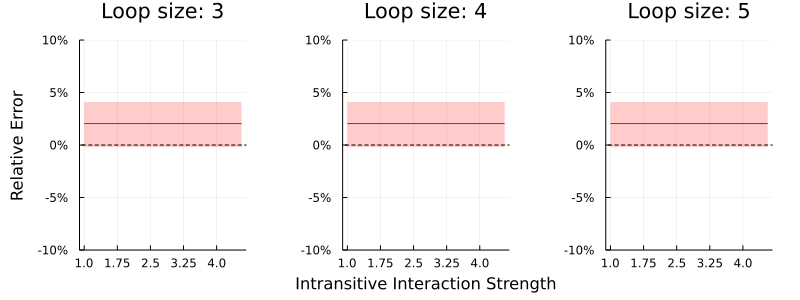

In [34]:
mean_err = mapslices(mean, res, dims = 3)[:,:,1]
err = mapslices(x -> abs.(mean(x) .- quantile(x, [0.05, 0.95])), res, dims = 3)

x_ticks = 1:4:N_B
x_ticklabs = string.(range(1.0, 4.0, length = length(x_ticks)))

y_ticks = -10:5:10
y_ticklabs = string.(y_ticks, "%")

p = [plot(mean_err[i,:],
        ribbon = ribbon = (err[i,:,1],err[i,:,2]),
        fillalpha = 0.2,
        legend = false,
        title = "Loop size: " * string(i),
        color = "red",
        xticks = (x_ticks, x_ticklabs),
        yticks = (y_ticks, y_ticklabs),
        ylim = (-10,10)
    )
    for i = 3:5]

hline!(p[1], [0.0], color = "black", style = :dash)
hline!(p[2], [0.0], color = "black", style = :dash)
hline!(p[3], [0.0], color = "black", style = :dash)



ylabel!(p[1],"Relative Error")
xlabel!(p[2],"Intransitive Interaction Strength")

p_ = plot(p..., layout = (1,3), link = :y, size = (800,300), margin = 5Plots.mm)


In [14]:
savefig(p_ , "../plots/FigS4_meanfield3.pdf")

Plot shows how increasing the relative weighting of intransitvie interactions marginally increases the error.

# Intransitive Biomass Amplifciation

Here we show how including intransitive network structure affects biomass amplification in a community. The approach here is to take a randomly generated community and shuffle the interactions between species such that the strongest and weakest interactions are aligned in an intransitive loop across the system. This generates two systems with identical distributions of interaction strengths but different interaction structures. Simulating many replicates of these two systems thus gives a way to assess the effects of adding intransitive structure on biomass dynamics

In [38]:
using Random

loop_max = 5

function intran_a(a,loop_max)
    N = size(a)[1]
    a_ordered = filter(x -> x != -10.0, a[:]) |> sort
    a_top = a_ordered[1:loop_max]
    a_bot = a_ordered[(end-loop_max) : end]

    a_sample = a_ordered[(loop_max + 1) : (N*(N-1)-loop_max)]
    Random.shuffle!(a_sample)

    #get indicies
    comb = combinations(1:N,loop_max) |> collect
    intrans_ind_1 = [[comb[1][i],circshift(comb[1],1)[i]] for i = 1:loop_max]
    intrans_ind_2 = [[circshift(comb[1],1)[i],comb[1][i]] for i = 1:loop_max]


    a_new = similar(a)
    for i = 1:N
        for j = 1:N
            if i == j
                a_new[i,j] = -10.0
            elseif [i,j] ∈ intrans_ind_1
                a_new[i,j] = a_top[1]
                deleteat!(a_top,1)
            elseif [i,j] ∈ intrans_ind_2
                a_new[i,j] = a_bot[1]
                deleteat!(a_bot,1)
            else
                a_new[i,j] = a_sample[1]
                deleteat!(a_sample,1)
            end

        end
    end

    return(a_new)

end



intran_a (generic function with 1 method)

In [39]:
#neutral case
N = 5
ā = 1.0

function total_biomass_simulaitons(N, ā)
    #initial community
    a = randn(N,N) ./ 5
    R = fill(1.0,N) .+ randn(N)./10
    r = fill(1.0,N) .+ randn(N)./10

    #competitive
    a_comp = a .- ā
    [a_comp[i,i] = -10.0 for i = 1:N]
    #intransitive
    a_intran = intran_a(a_comp,N)
    #neutral
    a_neutral = deepcopy(a)
    [a_neutral[i,i] = -10.0 for i = 1:N]
    #facilitation
    a_facil = a .+ ā
    [a_facil[i,i] = -10.0 for i = 1:N]

    #generate parameters
    p_comp = params(r,R,a_comp,ā,N)
    p_intran = params(r,R,a_intran,ā,N)
    p_neutral = params(r,R,a_neutral,ā,N)
    p_facil = params(r,R,a_facil,ā,N)


    C0 = rand(N) ./ 10
    tspan = (0.0,3.0)

    probs = [ODEProblem(dC!, C0, tspan, x) for x = [p_comp,p_intran,p_neutral,p_facil]]

    sols = solve.(probs,Ref(AutoTsit5(Rosenbrock23())), saveat = 0.1)

    total_biomss = vcat(map(x -> sum(x[:,:],dims=1),sols)...)
    return(total_biomss)
end


total_biomass_simulaitons (generic function with 1 method)

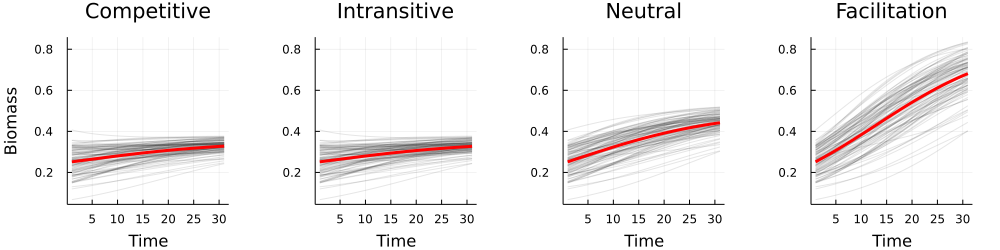

In [50]:
res = Array{Float64,3}(undef, 4,31,100)
[res[:,:,i] .= total_biomass_simulaitons(5, 1.0) for i = 1:100]

avg = mean(res,dims=3)[:,:,1]
var_ = var(res,dims=3)[:,:,1]
lb =  avg .- mapslices(x -> quantile(x,0.05), res, dims = 3)[:,:,1] 
ub =  mapslices(x -> quantile(x,0.95), res, dims = 3)[:,:,1] .- avg

# plot(avg', ribbon = (lb',ub'))
# plot!(lb')
# plot!(ub')


p = [plot(res[i,:,:], color = "black", alpha = 0.1) for i = 1:4]
[plot!(p[i],avg[i,:], color = "red", lw = 3) for i = 1:4]

title!(p[1], "Competitive")
title!(p[2], "Intransitive")
title!(p[3], "Neutral")
title!(p[4], "Facilitation")
yaxis!(p[1],"Biomass")

p = plot(p..., layout = (1,4), size = (1000,250), link = :y, legend = false, margin = 5Plots.mm)
xaxis!(p, "Time")

In [51]:
savefig(p, "../plots/FigS5_Intransitive_amp.pdf")